In [1]:
import boxball_loader as bbl
import baseball_stats_utils as bsu

In [2]:
# Use all game types for the input data, to measure history between batters and pitchers
# Narrow to RS/PS/whatever when looking at trends over time
ev = bbl.load_event_data(1800, 3000, ['bat_id', 'pit_id', 'event_id'], True, game_types=bbl.GameType.ALL).sort_values(['bat_id', 'pit_id', 'date', 'event_id'])
ev.columns

Index(['game_id', 'date', 'game_type', 'ab_fl', 'bat_event_fl', 'pit_id',
       'tb_ct', 'bat_id', 'event_cd', 'event_id', 'h_fl', 'ob_fl', 'yr'],
      dtype='object')

In [3]:
ev['game_type'].value_counts()

RS     13616184
PS       126144
ASG        6847
Name: game_type, dtype: int64

In [4]:
ev['matchup_ct_career'] = ev.groupby(['bat_id', 'pit_id']).cumcount()
ev['matchup_ct_season'] = ev.groupby(['bat_id', 'pit_id', 'yr']).cumcount()
ev['matchup_ct_game'] = ev.groupby(['bat_id', 'pit_id', 'game_id']).cumcount()
ev['first_matchup'] = (ev['matchup_ct_career']==0)
ev.sample(10)

,game_id,date,game_type,ab_fl,bat_event_fl,pit_id,tb_ct,bat_id,event_cd,event_id,h_fl,ob_fl,yr,matchup_ct_career,matchup_ct_season,matchup_ct_game,first_matchup
5226900,HOU196908050,1969-08-05,RS,True,True,lemad102,0,yound103,3,14,0,0,1969,3,3,0,False
11454360,OAK200605050,2006-05-05,RS,False,True,blanj001,0,gathj001,14,55,0,1,2006,4,2,2,False
7484946,SDN198404110,1984-04-11,RS,True,True,anduj001,1,gwynt001,20,40,1,1,1984,9,2,2,False
6911547,CAL198006080,1980-06-08,RS,True,True,aased001,0,dauer001,2,2,0,0,1980,19,0,0,False
12928067,TEX201308140,2013-08-14,RS,False,True,garzm001,0,bianj001,14,50,0,1,2013,3,3,2,False
2557855,NY1194504260,1945-04-26,RS,True,True,schac101,0,filis101,2,25,0,0,1945,1,1,1,False
8520816,SDN199005130,1990-05-13,RS,True,True,granm001,0,galaa001,3,52,0,0,1990,10,0,0,False
7110884,TEX198109050,1981-09-05,RS,True,True,petrd001,0,willb101,2,56,0,0,1981,11,7,2,False
3843688,SFN195805090,1958-05-09,RS,True,True,monzr101,2,gillj102,21,1,1,1,1958,16,3,0,False
5010555,CAL196804280,1968-04-28,RS,True,True,ellis101,0,jackr001,2,52,0,0,1968,3,3,2,False


## How much prior history is there on average for a batter-pitcher matchup?

For every plate appearance, count how many times these batter and pitcher have faced each other already.  Then average this across all PAs for each year, to view the trend over time.

<AxesSubplot:xlabel='yr'>

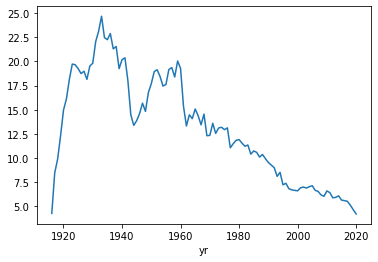

In [5]:
# Regular season matchups (includes history from regular season, post-season and ASG)
ev.query('game_type=="RS"').groupby('yr')['matchup_ct_career'].mean().plot()

<AxesSubplot:xlabel='yr'>

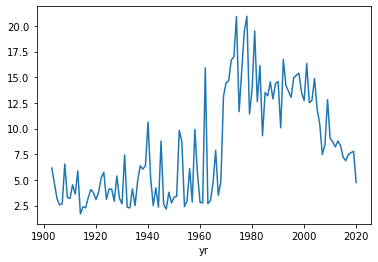

In [6]:
# Post-season matchups (includes history from regular season, post-season and ASG)
ev.query('game_type=="PS"').groupby('yr')['matchup_ct_career'].mean().plot()

In [7]:
# Let's summarize by decade, just to give us some numbers to use
decade = ((ev['yr']/10).astype(int)*10).rename('decade')
ev.groupby([decade, 'game_type'])['matchup_ct_career'].mean().unstack()[['RS', 'PS', 'ASG']]

game_type,RS,PS,ASG
decade,,,
1900,NaN,4.163110,NaN
1910,8.477079,3.528826,NaN
1920,18.392456,4.009259,NaN
1930,21.936391,4.469909,2.038314
1940,16.231658,4.677235,1.073134
1950,18.625141,5.778631,1.415600
1960,14.468753,6.733430,3.018000
1970,12.506017,16.337960,7.490814
1980,10.799469,14.489163,4.985333


<AxesSubplot:xlabel='yr'>

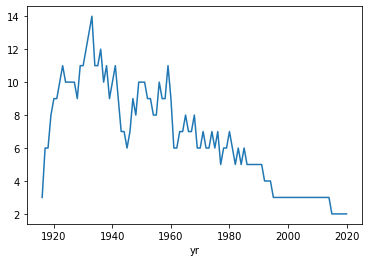

In [8]:
# Let's look at the median also

ev.query('game_type=="RS"').groupby('yr')['matchup_ct_career'].median().plot()

## What fraction of PAs are "new" batter-pitcher matchups (e.g., no prior history)?

,bat_event_fl,first_matchup,first_matchup_freq
yr,,,
1916,58873,11190,0.190070
1917,50560,5862,0.115941
1918,47035,5780,0.122887
1919,46792,5088,0.108737
1920,71700,6878,0.095927
...,...,...,...
2016,184580,44509,0.241137
2017,185295,45725,0.246769
2018,185139,47760,0.257968


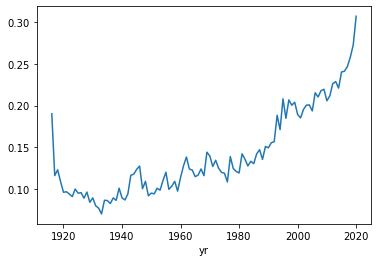

In [9]:
df = ev.query('game_type=="RS"').groupby('yr')[['bat_event_fl', 'first_matchup']].sum()
df['first_matchup_freq'] = (df['first_matchup']/df['bat_event_fl'])
df['first_matchup_freq'].plot()
df

In [10]:
# Summarize by decade
df = ev.query('game_type=="RS"').groupby(decade)[['bat_event_fl', 'first_matchup']].sum()
df['first_matchup_freq'] = (df['first_matchup']/df['bat_event_fl'])
df

,bat_event_fl,first_matchup,first_matchup_freq
decade,,,
1910,203260,27920,0.137361
1920,810276,75681,0.093402
1930,961766,81456,0.084694
1940,954454,100718,0.105524
1950,952828,97859,0.102704
1960,1209599,150915,0.124764
1970,1510990,189888,0.125671
1980,1551900,211184,0.136081
1990,1668131,306229,0.183576


## How many pitchers does a typical full-time hitter face in a season?

In [11]:
game_types_real = ['PS', 'RS'] # we want to exclude the ASG
pit_faced = ev.query('game_type in @game_types_real').groupby(['bat_id', 'yr'])['pit_id'].nunique().rename('pitcher_ct')
pit_faced.sample(10), pit_faced.sort_values().tail(10)

(bat_id    yr  
 wardc101  1972      1
 handl101  1946     81
 faheb101  1982     32
 wasdj101  1940     66
 redmt001  2001     60
 crowt101  1970     79
 youne003  2016      1
 gillg102  1929     28
 patef101  1972    112
 montw101  1981     56
 Name: pitcher_ct, dtype: int64,
 bat_id    yr  
 dozib001  2018    262
 pillk001  2019    262
 hernc005  2019    263
 castn001  2019    267
 brega001  2019    268
 bogax001  2019    268
 cespy001  2015    269
 mccua001  2018    273
 dever001  2019    275
 machm001  2018    286
 Name: pitcher_ct, dtype: int64)

<AxesSubplot:xlabel='yr'>

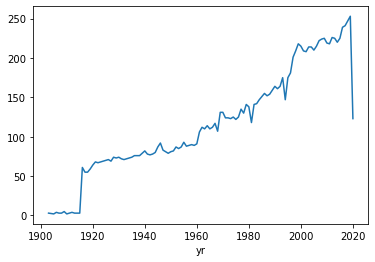

In [12]:
# For each year, choose the player with the 15th most pitchers faced in the year
pit_faced.sort_values(ascending=False).groupby('yr').nth(15).plot()

## How many distinct pitchers over a career?

In [13]:
pit_faced_career = ev.groupby('bat_id').agg(pitcher_ct=('pit_id', lambda x: x.nunique()), yr_last=('yr', max)).sort_values(by='pitcher_ct', ascending=False)
pit_faced_career.head(20)

,pitcher_ct,yr_last
bat_id,,
pujoa001,1609,2020
belta001,1557,2018
beltc001,1499,2017
vizqo001,1481,2012
rodra001,1456,2016
cabrm001,1406,2020
ortid001,1400,2016
rodri001,1373,2011
jeted001,1373,2014


In [14]:
# For comparison, let's look at someone who famously played in both leagues, but a couple generations ago
pit_faced_career.query('bat_id=="robif103"')

,pitcher_ct,yr_last
bat_id,,
robif103,715,1976


<AxesSubplot:xlabel='yr_last'>

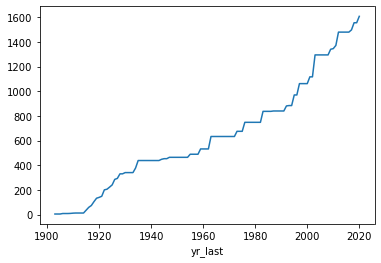

In [15]:
# How has the career record progressed over time?
# This isn't accurate because it's not looking at each player year-by-year; instead just looking at career totals and retirement year
pit_faced_career.groupby('yr_last')['pitcher_ct'].max().cummax().plot()

In [16]:
# Active-ish leaders -- anybody near Pujols?
pit_faced_career.query('yr_last>=2019').head(10)

,pitcher_ct,yr_last
bat_id,,
pujoa001,1609,2020
cabrm001,1406,2020
suzui001,1350,2019
canor001,1312,2020
moliy001,1309,2020
markn001,1288,2020
encae001,1274,2020
granc001,1256,2019
cabrm002,1227,2019


# Familiarity Effect
## What kind of advantages to we see to familiarity/unfamiliarity

##

In [17]:
# Start with a very simplified bucketing approach
buckets = bsu.summarize_events(ev, ['matchup_ct_career'])
buckets

,pa,ob,ab,h,tb,k,bb,ibb,hr,ba,obp,slg,woba,k%,bb%,hr%
matchup_ct_career,,,,,,,,,,,,,,,,
0,2099184,633112,1848767,443179,662207.0,399876,174281,12782,39082,0.239716,0.301599,0.358188,0.281547,0.190491,0.083023,0.018618
1,1541002,474796,1368266,344557,521314.0,256326,119437,10321,32092,0.251820,0.308109,0.381003,0.291759,0.166337,0.077506,0.020825
2,1186335,370671,1054927,271738,411627.0,181248,90731,8769,25458,0.257589,0.312451,0.390195,0.296622,0.152780,0.076480,0.021459
3,906605,284868,806403,207789,313199.0,137961,70909,6409,19062,0.257674,0.314214,0.388390,0.297409,0.152173,0.078214,0.021026
4,750395,236813,668452,173434,262589.0,110773,58354,5122,16223,0.259456,0.315584,0.392831,0.299734,0.147620,0.077764,0.021619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,1,0,0.0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
376,1,0,1,0,0.0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
377,1,1,1,1,1.0,0,0,0,0,1.000000,1.000000,1.000000,0.862000,0.000000,0.000000,0.000000


In [18]:
buckets['pa'].describe()

count    3.800000e+02
mean     3.618204e+04
std      1.705369e+05
min      1.000000e+00
25%      1.000000e+00
50%      1.050000e+02
75%      3.835750e+03
max      2.099184e+06
Name: pa, dtype: float64

<AxesSubplot:xlabel='matchup_ct_career'>

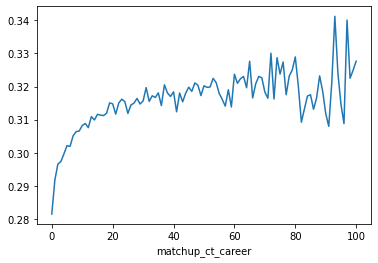

In [19]:
buckets.loc[0:100]['woba'].plot()

In [20]:
df = ev.query('1977<=yr<=2000').copy()
df

,game_id,date,game_type,ab_fl,bat_event_fl,pit_id,tb_ct,bat_id,event_cd,event_id,h_fl,ob_fl,yr,matchup_ct_career,matchup_ct_season,matchup_ct_game,first_matchup
8334661,NYN198904170,1989-04-17,RS,True,True,harrg001,0,aased001,3,55,0,0,1989,0,0,0,True
8382924,PIT198906100,1989-06-10,RS,True,True,heatn001,0,aased001,3,64,0,0,1989,0,0,0,True
8392355,NYN198906200,1989-06-20,RS,True,True,martd001,0,aased001,2,65,0,0,1989,0,0,0,True
8449233,NYN198908200,1989-08-20,RS,True,True,penaa001,0,aased001,2,57,0,0,1989,0,0,0,True
8323057,NYN198904030,1989-04-03,RS,True,True,worrt001,0,aased001,3,79,0,0,1989,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276013,CLE198808140,1988-08-14,RS,True,True,wittb001,0,zuvep001,3,18,0,0,1988,3,0,0,False
8276033,CLE198808140,1988-08-14,RS,False,True,wittb001,0,zuvep001,14,38,0,1,1988,4,1,1,False
8276050,CLE198808140,1988-08-14,RS,True,True,wittb001,0,zuvep001,2,55,0,0,1988,5,2,2,False
7804844,ATL198509280,1985-09-28,RS,True,True,wojne001,0,zuvep001,2,110,0,0,1985,0,0,0,True


In [21]:
df['matchup'] = df['pit_id'] + df['bat_id']
df

,game_id,date,game_type,ab_fl,bat_event_fl,pit_id,tb_ct,bat_id,event_cd,event_id,h_fl,ob_fl,yr,matchup_ct_career,matchup_ct_season,matchup_ct_game,first_matchup,matchup
8334661,NYN198904170,1989-04-17,RS,True,True,harrg001,0,aased001,3,55,0,0,1989,0,0,0,True,harrg001aased001
8382924,PIT198906100,1989-06-10,RS,True,True,heatn001,0,aased001,3,64,0,0,1989,0,0,0,True,heatn001aased001
8392355,NYN198906200,1989-06-20,RS,True,True,martd001,0,aased001,2,65,0,0,1989,0,0,0,True,martd001aased001
8449233,NYN198908200,1989-08-20,RS,True,True,penaa001,0,aased001,2,57,0,0,1989,0,0,0,True,penaa001aased001
8323057,NYN198904030,1989-04-03,RS,True,True,worrt001,0,aased001,3,79,0,0,1989,0,0,0,True,worrt001aased001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276013,CLE198808140,1988-08-14,RS,True,True,wittb001,0,zuvep001,3,18,0,0,1988,3,0,0,False,wittb001zuvep001
8276033,CLE198808140,1988-08-14,RS,False,True,wittb001,0,zuvep001,14,38,0,1,1988,4,1,1,False,wittb001zuvep001
8276050,CLE198808140,1988-08-14,RS,True,True,wittb001,0,zuvep001,2,55,0,0,1988,5,2,2,False,wittb001zuvep001
7804844,ATL198509280,1985-09-28,RS,True,True,wojne001,0,zuvep001,2,110,0,0,1985,0,0,0,True,wojne001zuvep001


In [22]:
threshold = 14
qualifying_matchups = df.groupby('matchup')['matchup_ct_career'].agg([min, max]).add_prefix('ct_').query('ct_min==0 and ct_max >=@threshold-1').index
qualifying_matchups

Index(['aased001adamg101', 'aased001armat001', 'aased001bailb001',
       'aased001bainh001', 'aased001bands101', 'aased001banna001',
       'aased001bayld001', 'aased001bellb001', 'aased001bochb001',
       'aased001bondb101',
       ...
       'zahng001whitr101', 'zahng001willb101', 'zahng001wilsg001',
       'zahng001wilsw001', 'zahng001wockj001', 'zahng001wooda001',
       'zahng001wrigg001', 'zahng001wyneb001', 'zahng001younr001',
       'zahng001zdebj101'],
      dtype='object', name='matchup', length=64500)

In [23]:
first_n = df.query('matchup in @qualifying_matchups and matchup_ct_career <@threshold')
first_n

,game_id,date,game_type,ab_fl,bat_event_fl,pit_id,tb_ct,bat_id,event_cd,event_id,h_fl,ob_fl,yr,matchup_ct_career,matchup_ct_season,matchup_ct_game,first_matchup,matchup
9881926,SEA199805050,1998-05-05,RS,True,True,fassj001,0,abboj002,2,16,0,0,1998,0,0,0,True,fassj001abboj002
9881945,SEA199805050,1998-05-05,RS,True,True,fassj001,0,abboj002,2,35,0,0,1998,1,1,1,False,fassj001abboj002
9881970,SEA199805050,1998-05-05,RS,True,True,fassj001,0,abboj002,2,60,0,0,1998,2,2,2,False,fassj001abboj002
9991986,CHA199808160,1998-08-16,RS,True,True,fassj001,0,abboj002,2,16,0,0,1998,3,3,0,False,fassj001abboj002
9992002,CHA199808160,1998-08-16,RS,True,True,fassj001,0,abboj002,2,32,0,0,1998,4,4,1,False,fassj001abboj002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9271418,DET199407051,1994-07-05,RS,True,True,welld001,0,zupcb001,2,68,0,0,1994,9,3,3,False,welld001zupcb001
9285422,CHA199407200,1994-07-20,RS,True,True,welld001,1,zupcb001,20,5,1,1,1994,10,4,0,False,welld001zupcb001
9285438,CHA199407200,1994-07-20,RS,True,True,welld001,0,zupcb001,2,21,0,0,1994,11,5,1,False,welld001zupcb001
9285461,CHA199407200,1994-07-20,RS,True,True,welld001,0,zupcb001,3,44,0,0,1994,12,6,2,False,welld001zupcb001


In [24]:
first_n['pit_id'].value_counts()

martd001    5558
morrj001    5236
clemr001    4704
darwd001    4592
herso001    4452
            ... 
olins001      14
boucd001      14
freid101      14
holms101      14
solaj001      14
Name: pit_id, Length: 997, dtype: int64

In [25]:
comparable_buckets = bsu.summarize_events(first_n, 'matchup_ct_career')
comparable_buckets

,pa,ob,ab,h,tb,k,bb,ibb,hr,ba,obp,slg,woba,k%,bb%,hr%
matchup_ct_career,,,,,,,,,,,,,,,,
0,64500,20351,57485,14493,21652,10962,5498,317,1278,0.252118,0.315519,0.376655,0.296521,0.169953,0.085240,0.019814
1,64500,20948,57748,15485,23242,9422,5074,403,1401,0.268148,0.324775,0.402473,0.308443,0.146078,0.078667,0.021721
2,64500,20903,57826,15692,23766,9128,4862,512,1468,0.271366,0.324078,0.410992,0.309630,0.141519,0.075380,0.022760
3,64500,20830,57764,15373,23190,9330,5102,419,1437,0.266135,0.322946,0.401461,0.307119,0.144651,0.079101,0.022279
4,64500,20736,57769,15315,23290,9355,5077,396,1470,0.265108,0.321488,0.403157,0.306998,0.145039,0.078713,0.022791
5,64500,20955,57808,15631,23858,9000,4971,437,1534,0.270395,0.324884,0.412711,0.311390,0.139535,0.077070,0.023783
6,64500,20732,57818,15413,23524,9173,4946,450,1494,0.266578,0.321426,0.406863,0.307652,0.142217,0.076682,0.023163
7,64500,20989,57732,15516,23721,9102,5088,418,1532,0.268759,0.325411,0.410881,0.311464,0.141116,0.078884,0.023752
8,64500,20855,57912,15603,24027,8951,4902,482,1627,0.269426,0.323333,0.414888,0.311088,0.138775,0.076000,0.025225


<AxesSubplot:xlabel='matchup_ct_career'>

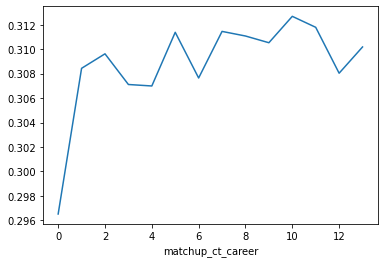

In [26]:
comparable_buckets['woba'].plot.line()